# Part A: Code

### QOL

In [1]:
import warnings
warnings.filterwarnings('ignore')

# To save .png or not to save .png, that is the question
save = True

### Helper Libraries

In [2]:
import numpy as np
import scipy.sparse as spsp
from scipy.sparse.linalg import spsolve
import scipy.integrate as integrate
from scipy.misc import derivative
import matplotlib.pyplot as plt

### Utility Classes

In [3]:
class Mesh:
    def __init__(self, points):
        # self.p    array with the node points (sorted) type : np.array dim: (n_p)
        # self.n_p  number of node points               type : int
        # self.s    array with indices of points per    type : np.array dim: (n_s, 2) 
        #           segment  
        # self.n_s  number of segments                  type : int
        # self.bc.  array with the indices of boundary  type : np.array dim: (2)
        #           points

        self.p   = points
        self.n_p = np.size(points,0)

        self.s   = np.vstack((range(self.n_p-1),range(1,self.n_p))).T
        self.n_s = self.n_p-1

        self.bc  = [0, self.n_p-1]


class V_h:
    def __init__(self, mesh):
        # self.mesh Mesh object containg geometric info type: Mesh
        # self.dim  dimension of the space              type: int

        self.mesh = mesh
        self.dim  = mesh.p.shape[0]

    def eval(self, xi, x):
        """ evaluation of the piece wise local polynomial given by
           the coefficients xi, at the point x 
        """

        # compute the index of the interval in which x is contained
        # Assumes valid input
        # Could optimize further with arrays
        num = False
        
        if type(x) is not np.ndarray and type(x) is not list:
            x_list = [x]
            num = True
        else:
            x_list = x
        x_list = np.array(x_list)
        
        out = []
        for xx in x_list:
            for i,p in enumerate(self.mesh.p):
                if p > xx:
                    break
            i-=1

            # compute the size of the interval
            h = self.mesh.p[i+1]-self.mesh.p[i]

            # here return the value of the function
            if i == np.size(xi)-1:
                ret = xi[i]
            else:
                ret = xi[i]*(1-(xx-self.mesh.p[i])/h) + xi[i+1]*(xx-self.mesh.p[i])/h
            out.append(ret)

        if num:
            return out[0]
        return np.array(out)

class Function:
    def __init__(self, xi, v_h):
        self.xi  = xi
        self.v_h = v_h

    def __call__(self,x):
        # wrapper for calling eval in V_h
        v_h = self.v_h

        # use the function defined in v_h
        return v_h.eval(self.xi, x)

### Finite Element Method

In [4]:
def mass_matrix(v_h):
    # sparse matrix easy to change sparsity pattern
    # this initializes an empty sparse matrix of 
    # size v_h.dim x v_h.dim
    M = spsp.lil_matrix((v_h.dim,v_h.dim))

    # for loop
    for i in range(v_h.mesh.n_s):
        # extract the indices
        inx = v_h.mesh.s[i]

        # compute the lengh of the segment
        h = v_h.mesh.p[inx[1]]-v_h.mesh.p[inx[0]]

        # add the values to the matrix
        M[i:i+2,i:i+2] += h*(np.identity(2)+1)/6

    return M


def stiffness_matrix(v_h, sigma):
    # matrix easy to change sparsity pattern
    S = spsp.lil_matrix((v_h.dim,v_h.dim))

    # for loop
    for i in range(v_h.mesh.n_s):
        # extract the indices
        inx = v_h.mesh.s[i]

        # compute the lengh of the segment
        h = v_h.mesh.p[inx[1]]-v_h.mesh.p[inx[0]]

        # sample sigma
        a_i = sigma((inx[1]+inx[0])/2)

        # update the stiffness matrix
        S[i:i+2,i:i+2] += (a_i/h)*(2*np.identity(2)-1)
        
    # No Kappa
    return S[1:-1,1:-1]

# show differences between Trapezoidal rule and Simpson rule
def load_vector(v_h, f):
    # allocate the vector
    b = np.zeros(v_h.dim)

    # for loop over the segments
    for i in range(v_h.mesh.n_s):
        # extracting the indices
        inx = v_h.mesh.s[i]

        # computing the length of the interval 
        h = v_h.mesh.p[inx[1]]-v_h.mesh.p[inx[0]]

        # update b
        b[i:i+2] += h*np.array([f(v_h.mesh.p[inx[0]]), f(v_h.mesh.p[inx[1]])]).T/2

    return b


def source_assembler(v_h, f, sigma, u_dirichlet):
    # computing the load vector (use the function above)
    b = load_vector(v_h,f)

    # extract the interval index for left boundary
    i_left = v_h.mesh.bc[0]

    # compute the length of the interval
    h = v_h.mesh.p[i_left+1]-v_h.mesh.p[i_left]

    # sample sigma at the middle point
    a_left = sigma((v_h.mesh.p[i_left+1]+v_h.mesh.p[i_left])/2)

    # update the source_vector
    b[1] += a_left/h * u_dirichlet[0]


    # extract the interval index for the right boudanry
    i_right = v_h.mesh.bc[1]

    # compute the length of the interval
    h = v_h.mesh.p[i_right]-v_h.mesh.p[i_right-1]
    
    # sample sigma at the middle point
    a_right = sigma((v_h.mesh.p[i_right]+v_h.mesh.p[i_right-1])/2)

    # update the source_vector
    b[-2] += a_right/h * u_dirichlet[1]

    # return only the interior nodes
    return b[1:-1]


def solve_poisson_dirichelet(v_h, f, sigma, 
                             u_dirichlet=np.zeros((2)) ):
    """ function to solbe the Poisson equation with 
    Dirichlet boundary conditions
    input:  v_h         function space
          f           load (python function)
          sigma       conductivity
          u_dirichlet boundary conditions
    output: u           approximation (Function class)
    """  

    # we compute the stiffness matrix, we only use the  
    # the interior dof, and we need to convert it to 
    # a csc_matrix
    S = spsp.csc_matrix(stiffness_matrix(v_h,sigma))
    # we build the source
    b = source_assembler(v_h,f,sigma,u_dirichlet)
    # solve for the interior degrees of freedom
    u_interior = spsolve(S,b)
    # concatenate the solution to add the boundary 
    # conditions
    xi_u = np.concatenate([u_dirichlet[:1], 
                         u_interior, 
                         u_dirichlet[1:]])

    # return the function
    return Function(xi_u, v_h)

### Projection/Interpolation Functions

In [5]:
def pi_h(v_h, f):
    """interpolation function
    input:  v_h   function space
            f     function to project
    output: pih_f function that is the interpolation 
                  of f into v_h
    """
    pi_h_f = -1
    pass

    return pi_h_f


def p_h(v_h, f):
    """projection function
    input:  v_h   function space
            f     function to project
    output: ph_f  function that is the projection 
                  of f into v_h
    """
    # compute load vector
    b = load_vector(v_h,f)

    # compute Mass matrix and convert it to csc type
    M = spsp.csc_matrix(mass_matrix(v_h))

    # solve the system
    xi = spsolve(M,b)

    # create the new function (this needs to be an instance)
    # of a Function class
    ph_f = Function(xi,v_h)

    return ph_f

### Verification Code

In [6]:
# Verify utility functionality
x = np.linspace(0,1,11)
mesh = Mesh(x)
v_h  = V_h(mesh)

f_load = lambda x: x**2
xi = f_load(x)
u = Function(xi, v_h) 
assert np.abs(u(x[5]) - f_load(x[5])) < 1.e-6
mid = (x[5] + x[6])/2
assert np.abs(u(mid) - f_load(mid)) < 1.e-2

# Verify projection
f_load = lambda x: 2+x*0
ph_f = p_h(v_h, f_load)
ph_f2 = p_h(v_h, ph_f)
assert np.max(ph_f.xi - ph_f2.xi) < 1.e-1

# Analytical solution
u = lambda x : np.sin(4.5*np.pi*x)
# Build source file
f = lambda x : (4.5*np.pi)**2*np.sin(4.5*np.pi*x)
# Boundary conditions
u_dirichlet = [u(0),u(1)]
# Constant Conductivity
sigma = lambda x : 1 + 0*x

# Solve
u_sol = solve_poisson_dirichelet(v_h, f, sigma, u_dirichlet)

# Estimate error
err = lambda x: np.square(u_sol(x) - u(x))
l2_err = np.sqrt(integrate.quad(err, 0.0,1.)[0])

print("L^2 error using %d points is %.6f"% (v_h.dim, l2_err))
# this should be quite large

# Use a finer mesh
x = np.linspace(0,1,41)
mesh = Mesh(x)
v_h  = V_h(mesh)

# Solve
u_sol = solve_poisson_dirichelet(v_h, f, sigma, u_dirichlet)

# Estimate error
err = lambda x: np.square(u_sol(x) - u(x))
l2_err = np.sqrt(integrate.quad(err, 0.0,1.)[0])

# Debugging step
if False:
    for i in range(21):
        print([u_sol(i/20),u(i/20)])
        
# print the error
print("L^2 error using %d points is %.6f"% (v_h.dim, l2_err))

L^2 error using 11 points is 0.125300
L^2 error using 41 points is 0.006896


# Problem B: Showcase Projection Convergence Properties

# Part B.1: h^4 Error Convergence

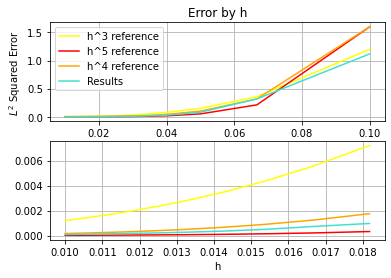

In [7]:
# Define f
f=lambda x : np.cos(12*np.pi*x)

# Take Samples
data=[]
for n in range(10,105,5):
    # Define Mesh
    x = np.linspace(0,1,n+1)
    mesh = Mesh(x)
    v_h  = V_h(mesh)

    # Calculate Projection
    ph_f = p_h(v_h, f)

    # Estimate error
    err = lambda x : np.square(f(x) - ph_f(x))
    l2_err_sq = integrate.quad(err, 0.0,1.)[0]

    # Print
    data.append([1/n,l2_err_sq])
data=np.array(data)

# Data for plotting
fig,pl = plt.subplots(2,1)
for i in range(len(pl)):
    pl[i].plot(data[:,0],1.2e+3*data[:,0]**3,
               label="h^3 reference",color="yellow")
    pl[i].plot(data[:,0],1.6e+5*data[:,0]**5,
               label="h^5 reference",color="red")
    pl[i].plot(data[:,0],1.6e+4*data[:,0]**4,
               label="h^4 reference",color="orange")
    pl[i].plot(data[:,0],data[:,1],
               label="Results",color="turquoise")
    
    pl[i].grid()
    if i==0:
        pl[i].set(ylabel="$L^2$ Squared Error",
                  title="Error by h")
        pl[i].legend()
    elif i==len(pl)-1:
        pl[i].set(xlabel="h")
    
    data = data[int(len(data)/2):]

if save:
    fig.savefig("B.1.png")
plt.show()

# Part B.2: Second Derivative Norm Convergence

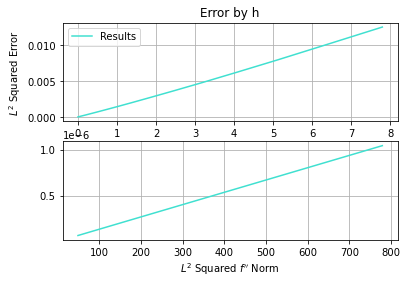

In [8]:
# Take Samples
data=[]
for c in range(1,21):
    # Define f
    f=lambda x : np.cos(c*np.pi*x)
    # Define f''
    f_2der=lambda x : -(c*np.pi)**2*np.cos(c*np.pi*x)
    
    # Define Mesh
    x = np.linspace(0,1,51)
    mesh = Mesh(x)
    v_h  = V_h(mesh)

    # Calculate Projection
    ph_f = p_h(v_h, f)

    # Estimate error
    err = lambda x : np.square(f(x) - ph_f(x))
    l2_err_sq = integrate.quad(err, 0.0,1.)[0]
    f2 = lambda x : np.square(f_2der(x))
    # We can sample the whole function because h_i = h_j
    l2_2der_sq = integrate.quad(f2, 0.0,1.)[0]

    # Print
    data.append([l2_2der_sq,l2_err_sq])
data=np.array(data)

# Data for plotting
fig,pl = plt.subplots(2,1)
for i in range(len(pl)):
    pl[i].plot(data[:,0],data[:,1],
               label="Results",color="turquoise")
    
    pl[i].grid()
    if i==0:
        pl[i].set(ylabel="$L^2$ Squared Error",
                  title="Error by h")
        pl[i].legend()
    elif i==len(pl)-1:
        pl[i].set(xlabel="$L^2$ Squared $f''$ Norm")
    
    data = data[:int(len(data)/8)]

if save:
    fig.savefig("B.2.png")
plt.show()

### Part B.3: Counter-Example

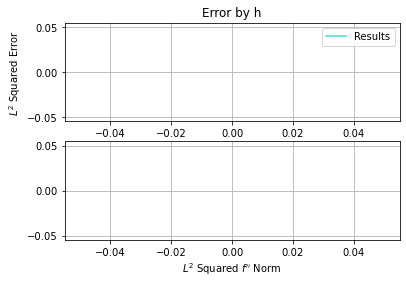

In [9]:
# Take Samples
data=[]
for c in range(1,21):
    # Define f (Can't use something like 1/x; Homogeneous/Dirichlet)
    f=lambda x : c/x
    # Define f''
    f_2der=lambda x : c*2/(x**3)
    
    # Define Mesh
    x = np.linspace(0,1,51)
    mesh = Mesh(x)
    v_h  = V_h(mesh)

    # Calculate Projection
    ph_f = p_h(v_h, f)

    # Estimate error
    err = lambda x : np.square(f(x) - ph_f(x))
    l2_err_sq = integrate.quad(err, 0.0,1.)[0]
    f2 = lambda x : np.square(f_2der(x))
    # We can sample the whole function because h_i = h_j
    l2_2der_sq = integrate.quad(f2, 0.0,1.)[0]

    # Print
    data.append([l2_2der_sq,l2_err_sq])
data=np.array(data)

# Data for plotting
fig,pl = plt.subplots(2,1)
for i in range(len(pl)):
    pl[i].plot(data[:,0],data[:,1],
               label="Results",color="turquoise")
    
    pl[i].grid()
    if i==0:
        pl[i].set(ylabel="$L^2$ Squared Error",
                  title="Error by h")
        pl[i].legend()
    elif i==len(pl)-1:
        pl[i].set(xlabel="$L^2$ Squared $f''$ Norm")
    
    data = data[:int(len(data)/8)]

if save:
    fig.savefig("B.3.png")
plt.show()

# Problem C

### Part C.a: Estimate Showcase

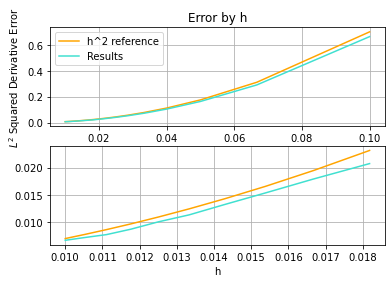

In [10]:
# Analytical solution
u = lambda x : np.sin(2*np.pi*x)
# Build source file
f = lambda x : (2*np.pi)**2*np.sin(2*np.pi*x)
# Boundary conditions
u_dirichlet = [u(0),u(1)]
# Constant Conductivity
sigma = lambda x : 1 + 0*x

# Take Samples
data=[]
for n in range(10,105,5):
    # Create Mesh
    x = np.linspace(0,1,n+1)
    mesh = Mesh(x)
    v_h  = V_h(mesh)

    # Solve
    u_sol = solve_poisson_dirichelet(v_h, f, sigma, u_dirichlet)

    # Estimate error
    diff = lambda x : u(x)-u_sol(x)
    # Take an FD estimation of (u - u_h)'
    err = lambda x : np.square(derivative(diff,x,dx=1e-3/n,n=1))
    l2_err_sq = integrate.quad(err, 0.0,1.)[0]
    
    data.append([1/n,l2_err_sq])
data=np.array(data)

# Data for plotting
fig,pl = plt.subplots(2,1)
for i in range(len(pl)):
    pl[i].plot(data[:,0],7e+1*data[:,0]**2,
               label="h^2 reference",color="orange")
    pl[i].plot(data[:,0],data[:,1],
               label="Results",color="turquoise")
    pl[i].grid()
    if i==0:
        pl[i].set(ylabel="$L^2$ Squared Derivative Error",
                  title="Error by h")
        pl[i].legend()
    elif i==len(pl)-1:
        pl[i].set(xlabel="h")
    
    data = data[int(len(data)/2):]

if save:
    fig.savefig("C.a.png")
plt.show()

### Part C.b.1: Adaptive Mesh Comparison

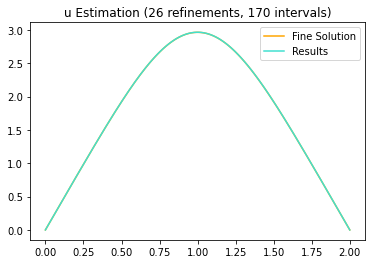

In [11]:
# Define domain length
L=2

# Create sources
sigma = lambda x : .1 + 0*x
f = lambda x : np.exp(-(x-L/2)**2/(2*sigma(x)))
u_dirichlet = [0,0]

# Find reference solution
x_fine = np.linspace(0,L,1001)
v_h_fine = V_h(Mesh(x_fine))
u=solve_poisson_dirichelet(v_h_fine, f, sigma, u_dirichlet)

# Create initial mesh
x = np.linspace(0,L,11)
v_h = V_h(Mesh(x))

l2_err = 9e+3; it=0
while True:
    # Iterate
    v_h = V_h(Mesh(x))
    
    # Estimate solution
    u_h=solve_poisson_dirichelet(v_h, f, sigma, u_dirichlet)

    # Compute error on current mesh
    err = lambda x : np.square(u(x)-u_h(x))
    l2_err = np.sqrt(integrate.quad(err,0,L)[0])
    
    if l2_err < 1e-3:
        break
    
    """
    # Element residual
    resid = np.zeros(len(x))
    for i in range(1,len(x)-1):
        h = max(x[i+1]-x[i],x[i]-x[i-1])
        d2 = (u(x[i]-h)-2*u(x[i])+u(x[i]+h))/h**2
        resid[i] = abs(f(x[i]) + .1*d2)
    """
    
    # Element residual
    rho = np.zeros(len(x)-1)
    for i in range(len(x)-1):
        h = x[i+1] - x[i]
        f_sq = lambda x : np.square(f(x))
        l2_i = np.sqrt(integrate.quad(f_sq,x[i],x[i+1])[0])
        rho[i] = h*l2_i
        
    """
    # Refine (ref will never be 0 or L unless exact)
    ref = np.argmax(resid+1)
    x=np.insert(x,ref+1,(x[ref]+x[ref+1])/2)
    x=np.insert(x,ref,(x[ref-1]+x[ref])/2)
    """
    
    # Refine
    alpha = .9
    for i in range(len(x)-1):
        if rho[i] > alpha*np.max(rho):
            x=np.append(x,(x[i]+x[i+1])/2)
    x=np.sort(x)
    
    it += 1
    #print(l2_err)

fig,pl = plt.subplots()
pl.plot(x_fine,u(x_fine),label="Fine Solution",color="orange")
pl.plot(x,u_h(x),label="Results",color="turquoise")
pl.set(title="u Estimation (%d refinements, %d intervals)" % (it,len(x)-1))
pl.legend()

if save:
    fig.savefig("C.b.1.png")
plt.show()

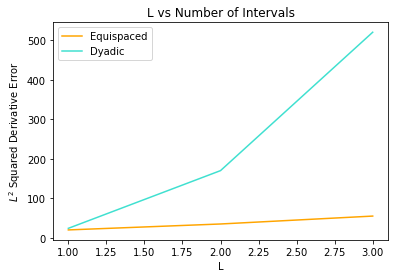

In [12]:
# Try and compare for multiple L
data = []
for L in range(1,4):
    # Create sources
    sigma = lambda x : .1 + 0*x
    f = lambda x : np.exp(-(x-L/2)**2/(2*sigma(x)))
    u_dirichlet = [0,0]

    # Find reference solution
    x_fine = np.linspace(0,L,1001)
    v_h_fine = V_h(Mesh(x_fine))
    u=solve_poisson_dirichelet(v_h_fine, f, sigma, u_dirichlet)

    # Create initial mesh
    x = np.linspace(0,L,11)
    v_h = V_h(Mesh(x))

    l2_err = 9e+3; it=0
    while True:
        # Iterate
        v_h = V_h(Mesh(x))

        # Estimate solution
        u_h=solve_poisson_dirichelet(v_h, f, sigma, u_dirichlet)

        # Compute error on current mesh
        err = lambda x : np.square(u(x)-u_h(x))
        l2_err = np.sqrt(integrate.quad(err,0,L)[0])

        if l2_err < 1e-3:
            break

        """
        # Element residual
        resid = np.zeros(len(x))
        for i in range(1,len(x)-1):
            h = max(x[i+1]-x[i],x[i]-x[i-1])
            d2 = (u(x[i]-h)-2*u(x[i])+u(x[i]+h))/h**2
            resid[i] = abs(f(x[i]) + .1*d2)
        """

        # Element residual
        rho = np.zeros(len(x)-1)
        for i in range(len(x)-1):
            h_i = x[i+1] - x[i]
            f_sq = lambda x : np.square(f(x))
            l2_i = np.sqrt(integrate.quad(f_sq,x[i],x[i+1])[0])
            rho[i] = h_i*l2_i

        """
        # Refine (ref will never be 0 or L unless exact)
        ref = np.argmax(resid+1)
        x=np.insert(x,ref+1,(x[ref]+x[ref+1])/2)
        x=np.insert(x,ref,(x[ref-1]+x[ref])/2)
        """

        # Refine
        alpha = .9
        for i in range(len(x)-1):
            if rho[i] > alpha*np.max(rho):
                x=np.append(x,(x[i]+x[i+1])/2)
        x=np.sort(x)

        it += 1
    intervals = len(x)-1
    
    l2_err = 9e+3; n=20#intervals
    while True:
        # Find reference solution
        x = np.linspace(0,L,n+1)
        v_h = V_h(Mesh(x))
        u_h = solve_poisson_dirichelet(v_h, f, sigma, u_dirichlet)
        
        # Compute error on current mesh
        err = lambda x : np.square(u(x)-u_h(x))
        l2_err = np.sqrt(integrate.quad(err,0,L)[0])
        
        if l2_err < 1e-3:
            break
        
        n += 5
    
    data.append([L,n,intervals])
    #print(data[-1])
    
data = np.array(data)
fig,pl = plt.subplots()
pl.plot(data[:,0],data[:,1],label="Equispaced",color="orange")
pl.plot(data[:,0],data[:,2],label="Dyadic",color="turquoise")
pl.set(xlabel="L",ylabel="$L^2$ Squared Derivative Error",title="L vs Number of Intervals")
pl.legend()

if save:
    fig.savefig("C.b.2.png")
plt.show()